In [1]:
import os
import sys
HOME = os.path.abspath('..')
sys.path.append(HOME)
os.chdir(HOME)
import pandas as pd
from ast import literal_eval
from imdb import Cinemagoer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import requests
from io import BytesIO
import re

# Meta data

In [217]:
# Read Data #
meta_data = pd.read_csv('../AllMoviesDetailsCleaned.csv',sep=';')

# movie meta data #


## Filter rows ##
meta_data['release_date'] = pd.to_datetime(meta_data['release_date'],errors='coerce')


#production_countries = meta_data['production_countries'].apply(extract_countries)
made_in_us = meta_data['production_countries']=='United States of America'

 #This can be changed to "made_in_us" filter instead of original language
mask1 = (meta_data['release_date'].dt.year>=1980)&\
        (meta_data['original_language']=='en')&\
        (meta_data['status']=='Released')

meta_data = meta_data[mask1]

## Format data ##
meta_data['imdb_id'] = pd.to_numeric(meta_data['imdb_id'].str.replace('tt',''),errors='coerce')
meta_data['budget'] = meta_data['budget'].astype(float)
meta_data['id'] = meta_data['id'].astype(int)


## Filter columns ##
meta_data_cols = [
                'title',
                'id',
                'imdb_id',
                'original_language',
                'original_title',
                'overview',
                #'poster_path',
                'production_companies',
                'budget',
                'genres',
                'production_countries',
                'release_date',
                'revenue',
                'runtime',
                'spoken_languages',
                'production_companies_number',
                'production_countries_number',
                'spoken_languages_number'
                    ]
meta_data = meta_data[meta_data_cols]


## Clean bad overviews ##
meta_data[meta_data['overview'].apply(lambda x: len(x) if isinstance(x,str) else x)<=2]=np.nan


## Drop duplicates and reset indexes ##
meta_data.drop_duplicates(subset=['imdb_id'],inplace=True)
meta_data.reset_index(drop=True,inplace=True)
meta_data.to_csv('data/processed/meta_data_cleaned.csv',index = False)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Posters

In [278]:
poster_ratings = pd.read_csv('data/raw/MovieGenre.csv',encoding = "ISO-8859-1")


# Posters dataset #
poster_ratings.drop_duplicates(subset=['imdbId'],inplace=True)
poster_ratings.reset_index(drop=True,inplace=True)


## rename columns ##
poster_ratings = poster_ratings[['imdbId','IMDB Score','Poster']]\
                            .rename(columns = {'imdbId':'imdb_id',
                                                'IMDB Score':'imdb_rating',
                                                'Poster':'poster_link'})

## format data ##
poster_ratings['imdb_id'] = poster_ratings['imdb_id'].astype(float)




poster_ratings.to_csv('data/processed/posters_links.csv',index = False)

# imdb data

In [218]:
#credits = pd.read_csv('credits.csv')
processed_meta_data = pd.read_csv('data/processed/meta_data_cleaned.csv')

names = pd.read_csv('data/raw/oficial_imdb_dataset/name.basics.tsv',
                    sep='\t',
                   usecols = ['nconst','primaryName'])

titles = pd.read_csv('data/raw/oficial_imdb_dataset/title.basics.tsv',
                     sep='\t',
                     usecols = ['tconst','titleType','genres','runtimeMinutes']
                    )
principals = pd.read_csv('data/raw/oficial_imdb_dataset/title.principals.tsv',
                         sep='\t')

ratings = pd.read_csv('data/raw/oficial_imdb_dataset/title.ratings.tsv',
                         sep='\t')

akas = pd.read_csv('data/raw/oficial_imdb_dataset/title.akas.tsv',
                         sep='\t')

imdb_ids_list = processed_meta_data['imdb_id'].unique()



# Titles #
titles['tconst'] = titles['tconst'].str.replace('tt','').astype(float)
titles.rename(columns = {'tconst':'imdb_id'},inplace=True)

titles = titles[titles['imdb_id'].isin(imdb_ids_list)]
titles = titles[titles['titleType']=='movie']

titles['genres'] = titles['genres'].str.lower().str.replace(',','|')


# Principals #
principals['tconst'] = principals['tconst'].str.replace('tt','').astype(float)
principals.rename(columns = {'tconst':'imdb_id'},inplace=True)

principals = principals[principals['imdb_id'].isin(imdb_ids_list)]
principals = principals.merge(names,on='nconst',how='left')
principals.replace({'actor':'cast',
                    'actress':'cast',
                    'self':'cast'},inplace=True)


## Sort by credits order
principals.sort_values(by = ['imdb_id','category','ordering'],ascending=True,inplace=True)

## Create grouped version of principals
top_n = 3

principals['primaryName'] = principals['primaryName'].fillna('')

grouped_principals = principals\
                    .groupby(['imdb_id','category'])['primaryName']\
                    .apply(lambda x: '|'.join(x.iloc[:top_n].tolist() ))\
                    .reset_index()


grouped_principals = grouped_principals.pivot(columns = 'category',
                                              index = 'imdb_id',
                                              values='primaryName')\
                    .reset_index()\
                    .rename_axis(None, axis=1)


# filter columns and normalize 
cols = ['imdb_id','director','cast']
grouped_principals = grouped_principals[cols]

categ = grouped_principals.columns[grouped_principals.dtypes==object]
grouped_principals[categ] = grouped_principals[categ].apply(lambda x: x.str.lower().str.strip(),axis=1)

# Ratings #
ratings['tconst'] = ratings['tconst'].str.replace('tt','').astype(float)
ratings.rename(columns = {'tconst':'imdb_id'},inplace=True)

#Merge everything
titles = titles.merge(grouped_principals,how='left',on='imdb_id')
titles = titles.merge(ratings,how='left',on='imdb_id')
titles.to_csv('data/processed/imdb.csv',index=False)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Merge

In [668]:
# Read data
box_office_mojo_data_v2 = pd.read_csv('data/processed/box_office_mojo_data_v2.csv')
processed_meta_data = pd.read_csv('data/processed/meta_data_cleaned.csv')
titles = pd.read_csv('data/processed/imdb.csv')
imdb_api_data = pd.read_csv('data/processed/imdb_api_data.csv') #TODO: Create this csv

#Rename Columns
box_office_mojo_data_v2.rename(columns = {i:f'revenue_{i.lower()}_BOM'for i in box_office_mojo_data_v2.columns[:3]},
                              inplace=True)



In [669]:
# MERGE #
df = titles.merge(processed_meta_data.drop(['genres'],axis=1),
                  how = 'left',
                  on='imdb_id')

df = df.merge(poster_ratings,
              how = 'left',
              on='imdb_id')

df = df.merge(box_office_mojo_data_v2,
              how='left',
              on='imdb_id')

df[['imdb_id']].to_csv('data/processed/filtered_id_list.csv',index=False)

In [670]:
df = df.dropna(subset=['revenue_worldwide_BOM'])

#Final language filter
df = df[df['spoken_languages']=='English']
df = df.reset_index(drop=True).sort_values(by='imdb_id')


df.drop(['titleType',
         'director',
         'id',
         'original_language',
         'production_companies',
         'production_countries',
         'budget',
         'revenue',
         'runtime',
         'spoken_languages',
         'imdb_rating'],
        axis=1,
        inplace=True)



df = df.merge(imdb_api_data,how='left',on='imdb_id')
df.to_csv('data/processed/df.csv',index=False)

# IMDB api data

In [471]:
import pickle
from glob import glob


def extract_from_list_col(dataframe,col,max_items=4,normalize=True):
    return dataframe[col].apply(lambda x: extract_from_list(x,
                                                            max_items=max_items,
                                                            normalize=normalize))

def extract_from_list(list_,max_items=4,normalize=True):

    if isinstance(list_,list):
        if normalize:
            list_ = [i.lower().strip() for i in list_[:4]]
        else:
            list_ = list_[:4]
    else:
        return np.nan
        
    return '|'.join(list_)


# Get Data From API

cg = Cinemagoer()
cols = ['director',
        'countries',
        'country codes',
        'language codes',
        'languages',
        'box office',
        'cover url',
        'full-size cover url',
        'production companies']


remaining_ids = df['imdb_id'].values


#Continue where we left off
files_names = glob('data/raw/imdb_api_chkp_*.pickle')
if files_names:
    loaded_ids = []
    for i in files_names:
        with open(i, 'rb') as handle:
            b = pickle.load(handle) 
        loaded_ids.extend([j['imdb_id'] for j in b])
        
remaining_ids = list(set(remaining_ids) - set(loaded_ids))
num_movies = len(remaining_ids)

print(f'fetching data of {num_movies} movies')
c=1

rows = []
for imdb_id in remaining_ids:
    obj = cg.get_movie(imdb_id)
    row = {'imdb_id':imdb_id}

    for col in cols:

        try:
            row[col] = obj[col]
            if col == 'production companies':
                row[col] = [i['name'] for i in row['production companies']]
            if col == 'director':
                row[col] = [i['name'] for i in row['director']]
            if col == 'box office':
                for k,v in row['box office'].items():
                    row[k]=v
                row.pop('box office')
        except KeyError:
            row[col] = np.nan
    
    rows.append(row)

    if c%100==0:
        print(round(c*100/num_movies,2))
        with open(f'data/raw/imdb_api_chkp_{c}_{imdb_id}.pickle', 'wb') as handle:
            pickle.dump(rows, handle, protocol=pickle.HIGHEST_PROTOCOL)
        rows = []
    
    c+=1
    
    

# Generate dataframe from downloaded data
files_names = glob('data/raw/imdb_api_chkp_*.pickle')
if files_names:
    data = []
    for i in files_names:
        with open(i, 'rb') as handle:
            b = pickle.load(handle) 
        data.extend(b)
        
data = pd.DataFrame(data)


# Clean a bit

data['Opening Weekend'] = data[[i for i in data.columns if 'Opening Weekend' in i]].apply(lambda x: x.dropna().sum(), axis=1)

data = data[['imdb_id',
             'director', 
             'countries', 
             'country codes', 
             'language codes',
             'languages', 
             'Budget', 
             'cover url', 
             'full-size cover url',
             'production companies',
             'Opening Weekend']]

list_cols = ['director',
             'countries',
             'country codes',
             'language codes',
             'languages',
             'production companies']

for i in list_cols:
    data.loc[:,i] = extract_from_list_col(data,i)
    
    
# Save
data.to_csv('data/processed/imdb_api_data.csv',index=False)

fetching data of 11479 movies
0.87
1.74
2.61
3.48
4.36
5.23
6.1
6.97
7.84
8.71
9.58
10.45
11.33
12.2
13.07
13.94
14.81
15.68
16.55
17.42
18.29
19.17
20.04
20.91
21.78
22.65
23.52
24.39
25.26
26.13
27.01
27.88
28.75
29.62
30.49
31.36
32.23
33.1
33.98
34.85
35.72
36.59
37.46
38.33
39.2
40.07
40.94
41.82
42.69
43.56
44.43
45.3
46.17
47.04
47.91
48.78
49.66
50.53
51.4
52.27
53.14
54.01
54.88
55.75
56.63
57.5
58.37
59.24
60.11
60.98
61.85
62.72
63.59
64.47
65.34
66.21
67.08
67.95
68.82
69.69
70.56
71.43
72.31
73.18
74.05
74.92
75.79
76.66
77.53
78.4
79.28
80.15
81.02
81.89
82.76
83.63
84.5
85.37
86.24
87.12
87.99
88.86
89.73
90.6
91.47
92.34
93.21
94.08
94.96
95.83
96.7
97.57
98.44
99.31


In [142]:

df=df.sort_values(by='release_date',ascending=True)

train_proportion =.7
train_val_split = int(round(len(df)*train_proportion))
val_test_split = int(round(len(df)*(train_proportion+(1-train_proportion)/2)))

train_ids = df[:train_val_split]['imdb_id']
val_ids = df[train_val_split:val_test_split]['imdb_id'].values
test_ids = df[val_test_split:]['imdb_id'].values

df[df['imdb_id'].isin(train_ids)].to_csv('data/processed/train.csv',index=False)
df[df['imdb_id'].isin(val_ids)].to_csv('data/processed/val.csv',index=False)
df[df['imdb_id'].isin(test_ids)].to_csv('data/processed/test.csv',index=False)

In [147]:
df = pd.read_csv('data/processed/df.csv',parse_dates=['release_date'])

In [164]:
(df['numVotes']>500).sum()

10527

In [161]:
(df['director']=='').sum()

0

In [126]:
(train_proportion+(1-train_proportion)/2)

0.85

<AxesSubplot:>

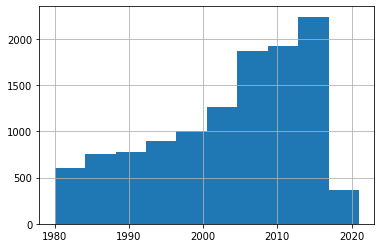

In [124]:
df.release_date.dt.year.hist()

In [47]:
titles = pd.read_csv('data/processed/imdb.csv')

In [79]:
a=df.merge(titles,how = 'left',on='imdb_id').dropna()

In [81]:
a[(a['director_x']!=a['director_y'])][['imdb_id','director_x','director_y']]

,imdb_id,director_x,director_y
3037,118577.0,arthur hiller|alan smithee,arthur hiller
3465,120910.0,james algar|gaëtan brizzi|paul brizzi|hendel b...,james algar|gaëtan brizzi|paul brizzi
4358,259974.0,bob buchholz|mamoru hosoda|jeff nimoy|shigeyas...,bob buchholz|mamoru hosoda|jeff nimoy
4483,275847.0,dean deblois|chris sanders,dean deblois
4757,308353.0,paul bolger|yvette kaplan|greg tiernan|dino at...,paul bolger|yvette kaplan|greg tiernan
5282,373445.0,andrew wilson|luke wilson,andrew wilson
5345,378407.0,jon gunn|brian herzlinger|brett winn,jon gunn|brett winn
5594,403703.0,christopher collet|eric stuart|hatsuki tsuji,christopher collet|hatsuki tsuji
7362,1058017.0,ricky gervais|matthew robinson,matthew robinson
7607,1152822.0,heidi ewing|alex gibney|seth gordon|rachel grady,heidi ewing|alex gibney|seth gordon


In [82]:
titles[titles['imdb_id']==118577.0]

,imdb_id,titleType,runtimeMinutes,genres,director,cast,averageRating,numVotes
10572,118577.0,movie,86,comedy,arthur hiller,ryan o'neal|coolio|chuck d,3.5,3602.0


In [75]:
df[(a['director_x']!=a['director_y'])]

,imdb_id,runtimeMinutes,genres,cast,averageRating,numVotes,title,original_title,overview,release_date,...,director,countries,country codes,language codes,languages,Budget,cover url,full-size cover url,production companies,Opening Weekend
15,80461.0,75,adventure|animation|comedy,scott beach|bill melendez|daniel anderson,7.2,3161.0,"Bon Voyage, Charlie Brown (and Don't Come Back!)","Bon Voyage, Charlie Brown (and Don't Come Back!)","Charlie Brown, Linus, Peppermint Patty and Mar...",1980-01-01,...,bill melendez|phil roman,united states,us,en|fr,english|french,NaN,https://m.media-amazon.com/images/M/MV5BYjhhOG...,https://m.media-amazon.com/images/M/MV5BYjhhOG...,lee mendelson film productions|bill melendez p...,0
17,80472.0,116,action|adventure|comedy,clint eastwood|sondra locke|geoffrey lewis,6.1,11723.0,Bronco Billy,Bronco Billy,"An idealistic, modern-day cowboy struggles to ...",1980-11-06,...,clint eastwood,united states,us,en,english,"$6,500,000 (estimated)",https://m.media-amazon.com/images/M/MV5BODg3MG...,https://m.media-amazon.com/images/M/MV5BODg3MG...,warner bros.|second street films,"$3,708,710, 15 Jun 1980"
21,80520.0,99,comedy|crime|sci-fi,cheech marin|tommy chong|evelyn guerrero,6.0,13935.0,Cheech & Chong's Next Movie,Cheech & Chong's Next Movie,Perennially stoned Cheech and Chong tear throu...,1980-07-18,...,tommy chong,united states,us,en,english,NaN,https://m.media-amazon.com/images/M/MV5BODk3Ym...,https://m.media-amazon.com/images/M/MV5BODk3Ym...,universal pictures,"$5,262,963, 20 Jul 1980"
31,80731.0,100,comedy|crime|fantasy,peter sellers|helen mirren|david tomlinson,4.9,2173.0,The Fiendish Plot of Dr. Fu Manchu,The Fiendish Plot of Dr. Fu Manchu,Fu Manchu's 168th birthday celebration is damp...,1980-08-08,...,piers haggard|richard quine|peter sellers,united states,us,en,english,NaN,https://m.media-amazon.com/images/M/MV5BYTUxND...,https://m.media-amazon.com/images/M/MV5BYTUxND...,braun entertainment group|playboy enterprises,"$2,399,109, 10 Aug 1980"
41,80808.0,89,comedy,chuck barris|robin altman|brian o'mullin,4.3,839.0,The Gong Show Movie,The Gong Show Movie,"A week in the life of ""The Gong Show"" host and...",1980-05-23,...,chuck barris,united states,us,en,english,NaN,https://m.media-amazon.com/images/M/MV5BY2I1ZG...,https://m.media-amazon.com/images/M/MV5BY2I1ZG...,chuck barris productions|universal pictures,"$1,476,425, 26 May 1980"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11629,6217804.0,101,comedy|drama|horror,tyler perry|cassi davis|patrice lovely,3.8,4683.0,Boo 2! A Madea Halloween,Boo 2! A Madea Halloween,"Madea and the gang encounter monsters, goblins...",2017-10-20,...,tyler perry,united states,us,en,english,"$25,000,000 (estimated)",https://m.media-amazon.com/images/M/MV5BZTI5YW...,https://m.media-amazon.com/images/M/MV5BZTI5YW...,the tyler perry company,"$21,226,953, 22 Oct 2017"
11642,6338476.0,103,comedy|drama,daniel radcliffe|owen wilson|woody harrelson,6.2,4023.0,Lost in London,Lost in London,"Within the course of a night, Woody Harrelson ...",2017-01-19,...,woody harrelson,united states|united kingdom,us|gb,en,english,NaN,https://m.media-amazon.com/images/M/MV5BMWUzMm...,https://m.media-amazon.com/images/M/MV5BMWUzMm...,pixoloid studios|waypoint entertainment,0
11644,6370614.0,90,documentary,travis wilkerson|ed vaughn,6.7,484.0,Did You Wonder Who Fired the Gun?,Did You Wonder Who Fired the Gun?,A documentary murder mystery about the filmmak...,2017-01-20,...,travis wilkerson,united states,us,en,english,NaN,https://m.media-amazon.com/images/M/MV5BNTY0Nj...,https://m.media-amazon.com/images/M/MV5BNTY0Nj...,canada council for the arts|creative capital,0
11656,6598626.0,83,comedy|crime|mystery,pat healy|taylor schilling|alycia delmore,6.1,5547.0,Take Me,Take Me,Ray is a fledgling entrepreneur who specialize...,2017-05-05,...,pat healy,united states,us,en,english,NaN,https://m.media-amazon.com/images/M/MV5BMTQ5Mj...,https://m.media-amazon.com/images

In [62]:
a['director_x'].isna().sum()

0

In [63]:
a['director_y'].isna().sum()

0

In [27]:
from src.data.imdb_api_data import IMDBApiDataLoader

In [28]:
idl = IMDBApiDataLoader()

In [4]:
idl.download_from_api([1877830],movies_per_file=1)
a=idl.to_df()
a = idl.clean(a)

fetching data of 0 movies


In [29]:
from src.data.box_office_mojo_scraper import BoxOfficeMojoScraper

In [30]:
BoxOfficeMojoScraper

src.data.box_office_mojo_scraper.BoxOfficeMojoScraper

In [2]:
from decimal import Decimal


In [3]:
df = pd.read_csv('data/processed/df.csv')

In [88]:
os.path.exists('data/processed/posters')

True

In [110]:
11000*.15

1650.0